# Nonlinear Finite-Difference Time-Domain (FDTD)
### by Jay Zou for APHY 679

In this notebook, we will develop a basic 1D FDTD code from scratch. Covering the basics for the FDTD update equations, sources, electric boundary conditions, absorbing boundary conditions, linear dielectric response, second order nonlinear reponse, from which we are able to see second harmonic generation.

We begin by installing some packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

We then define our physical constants

In [2]:
epsilon0 = 8.85418782e-12 #F⋅m−1
mu0 = 1.25663706e-6 #N⋅A−2

Which allows us to calculate the speed of light, which we can verify to be the speed of light.

In [3]:
c0 = 1/np.sqrt(epsilon0*mu0)
c0

299792458.13099605

Now, we will develop the update equations for FDTD through finite difference derivatives and Maxwell's equations.

## Finite-difference derivatives

In order to evaluate the derivative of a function $f(x)$ at $x_0$, we need to evaluate the function at $x_0 \pm \frac{\Delta x}{2}$ for a sufficiently small $\Delta x$. We call this a "full-step" derivative,
$$
\frac{df}{dx}(x_0) \approx \frac{f(x_0 + \frac{\Delta x}{2}) - f(x_0 - \frac{\Delta x}{2})}{\Delta x}.
$$
Similarly, we also define the "half-step" derivative,
$$
\frac{df}{dx}(x_0 + \frac{\Delta x}{2}) \approx \frac{f(x_0 + \Delta x) - f(x_0)}{\Delta x}.
$$

## Maxwell's equations

In general, Maxwell's equations are used to describe electrodynamics. Starting with the divergence equations, where $\vec{D}$ is the electric displacement field and $\vec{B}$ the magnetic displacement field,
$$
\nabla \cdot \vec{D} = \rho_v,\\
\nabla \cdot \vec{B} = 0.
$$
These equations describe how electric and magnetic fields behave in the presence of sources.
The curl equations describe how the fields interact with each other:
$$
\nabla \times \vec{E} = -\frac{\partial \vec{B}}{\partial t},\\
\nabla \times \vec{H} = \frac{\partial \vec{D}}{\partial t} + \vec{J}.
$$
The constitutive relations describe how the fields interact with matter:
$$
\vec{D}(t) = \epsilon(t) * \vec{E}(t),\\
\vec{B}(t) = \mu(t) * \vec{H}(t),
$$
where $\epsilon(t)$ and $\mu(t)$ are the permittivity and permeability, respectively, generally described as tensors to accommodate anisotropy and time-dependent to describe frequency dependence.

## Some key assumptions

We will make some simplifications:
1. Assume no point and current source terms:
$$
\nabla \cdot \vec{D} = \rho_v,\\
\nabla \cdot \vec{B} = 0,\\
\nabla \times \vec{E} = -\frac{\partial \vec{B}}{\partial t},\\
\nabla \times \vec{H} = \frac{\partial \vec{D}}{\partial t}.
$$
2. Assume a linear, isotropic, and dispersion-free medium:
$$
\vec{D}(t) = \epsilon \vec{E}(t),\\
\vec{B}(t) = \mu \vec{H}(t).
$$
3. Assume the field is propagating in the y-direction and the field is x-polarized:
$$
\vec{\nabla} \times \vec{E} = \left( 0, 0, -\frac{\partial E_x}{\partial y} \right),\\
\vec{\nabla} \times \vec{H} = \left( 0, 0, \frac{\partial H_z}{\partial y} \right).
$$

## Deriving the update equations of FDTD

We are now ready to derive the update equations of FDTD. Starting with the electric curl equation using a full-step derivative,
$$
\begin{aligned}
\frac{\partial E_x}{\partial y} &= \mu \frac{\partial H_z}{\partial t},\\
\frac{\partial E_x}{\partial y} (t) &= \mu \frac{H_z(t + \frac{\Delta t}{2}) - H_z(t - \frac{\Delta t}{2})}{\Delta t}.
\end{aligned}
$$
Similarly, with the magnetic curl equation using a half-step derivative,
$$
\begin{aligned}
\frac{d H_z}{d y} &= \epsilon \frac{dE_x}{d t},\\
\frac{d H_z}{d y} (t+\frac{\Delta t}{2}) &= \epsilon \frac{E_x(t + \Delta t) - E_x(t)}{\Delta t}.
\end{aligned}
$$

By isolating the term one time-step in the futre, we get
$$
\begin{aligned}
H_z(t + \frac{\Delta t}{2}) &= H_z(t - \frac{\Delta t}{2})+\Delta t \frac{1}{\mu}\frac{d E_x}{d y}(t),\\
E_x(t + \Delta t) &= E_x(t)+\Delta t\frac{1}{\epsilon}\frac{d H_z}{d y}(t+\frac{\Delta t}{2}).
\end{aligned}
$$
We can similarly include the spacial derivatives, starting with the electric fields
$$
\begin{aligned}
\frac{d E_x}{d y} (t) &= \mu \frac{H_z(t + \frac{\Delta t}{2}) - H_z(t - \frac{\Delta t}{2})}{\Delta t}\\
\frac{E_x(y + \Delta y, t) - E_x(y, t)}{\Delta y} &= \mu \frac{H_z(y + \frac{\Delta y}{2}, t+\frac{\Delta t}{2}) - H_z(y + \frac{\Delta y}{2}, t-\frac{\Delta t}{2})}{\Delta t},
\end{aligned}
$$
and the magnetic fields,
$$
\begin{aligned}
\frac{d H_z}{d y} (t+\frac{\Delta t}{2}) &= \epsilon \frac{E_x(t + \Delta t) - E_x(t)}{\Delta t}\\
\frac{H_z(y + \frac{\Delta y}{2}, t) - H_z(y - \frac{\Delta y}{2}, t)}{\Delta y} &= \epsilon \frac{E_x(y, t + \Delta t) - E_x(y, t)}{\Delta t}.
\end{aligned}
$$

Putting this all together, we get our update equations
$$
\begin{aligned}
H_z(y + \frac{\Delta y}{2}, t+\frac{\Delta t}{2}) = H_z(y + \frac{\Delta y}{2}, t-\frac{\Delta t}{2})+ \Delta t\frac{E_x(y + \Delta y, t) - E_x(y, t)}{\mu \Delta y},\\
E_x(y, t + \Delta t) = E_x(y, t) + \Delta t \frac{H_z(y + \frac{\Delta y}{2}, t) - H_z(y - \frac{\Delta y}{2}, t)}{\epsilon \Delta y}.
\end{aligned}
$$

Since we are coding this on a computer, we will replace $t, t + \Delta t$ as $n, n+1$ and $y - \frac{\Delta y}{2}, y + \frac{\Delta y}{2}$ as $j, j-1$.

$$
\begin{aligned}
H_z[j, n] &= H_z[j, n-1] + \frac{\Delta t}{\mu \Delta y} \left( E_x[j+1, n] - E_x[j, n] \right), \\
E_x[j, n+1] &= E_x[j, n] + \frac{\Delta t}{\epsilon \Delta y} \left( H_z[j, n] - H_z[j - 1, n] \right).
\end{aligned}
$$

In order the ensure convergence, we will set $\Delta x=\lambda/(20*10)$ (since typically we scale by a factor of 20, but we will also be using carrier frequencies that are 10 times quicker than the envelope function) and $\Delta t = \Delta x / c_0$ where $c_0$ is the speed of light.

We can finally start constructing our FDTD code!

In [4]:
jmax = 1000 # Total number of space steps
nmax = 5000 # Total number of time steps

In [5]:
wavelength = 300e-9 #lambda = 300nm
dx = wavelength/200
dt = dx/c0

### FDTD Update Equations Pseudocode

```plaintext
Initialize Hz_all and Ex_all arrays with appropriate dimensions and initial conditions of 0

FOR n = 1 TO nmax - 1
    FOR j = 0 TO jmax - 2
        Hz_all[n + 1, j] = Hz_all[n, j] + (dt / (dx * mu0)) * (Ex_all[n, j + 1] - Ex_all[n, j])
    ENDFOR

    FOR j = 1 TO jmax - 1
        Ex_all[n + 1, j] = Ex_all[n, j] + (dt / (dx * eps)) * (Hz_all[n + 1, j] - Hz_all[n + 1, j - 1])
    ENDFOR
ENDFOR


In [6]:
Ex_all = np.zeros((nmax, jmax))
Hz_all = np.zeros((nmax, jmax))

eps = epsilon0

# Simulation loop
for n in range(1, nmax): # Looping across all time steps
    for j in range(jmax-1): # Looping across all space steps
        Hz_all[n, j] = Hz_all[n-1, j] + dt / (dx * mu0) * (Ex_all[n-1, j+1] - Ex_all[n-1, j]) # Updating Hz
    for j in range(1, jmax): # Looping across all space steps
        Ex_all[n, j] = Ex_all[n-1, j] + dt / (dx * eps) * (Hz_all[n, j] - Hz_all[n, j-1]) #  pdating Ex

def plot_frame(n=0):
    plt.figure(figsize=(8, 5))
    plt.plot(Ex_all[n, :])
    plt.title(f"Electric Field at Time Step: {n}")
    plt.ylim(-1.5, 1.5)
    plt.show()

# Create an interactive widget
interact(plot_frame, n=IntSlider(min=0, max=nmax-1, step=1, value=0, description='Time Step'))

interactive(children=(IntSlider(value=0, description='Time Step', max=4999), Output()), _dom_classes=('widget-…

<function __main__.plot_frame(n=0)>

Of course the electric field is 0 everywhere, since we have not introduced any sources!

### Adding sources

To add a source term, we just need to define a time-dependent source term and update the approxiate values of Ex[n, jsource]

In [7]:
jsource = 300 # Position of a source term

def source_pulse(t):
    carrier_wavelength = wavelength/10
    w0 = 2*np.pi*c0/carrier_wavelength
    width = 60
    
    return np.exp(-((t-width*3)**2)/width**2)*np.sin(w0*t*dt)

In [8]:
Ex_all = np.zeros((nmax, jmax))
Hz_all = np.zeros((nmax, jmax))

eps = epsilon0

# Simulation loop
for n in range(1, nmax): # Looping across all time steps
    for j in range(jmax-1): # Looping across all space steps
        Hz_all[n, j] = Hz_all[n-1, j] + dt / (dx * mu0) * (Ex_all[n-1, j+1] - Ex_all[n-1, j]) # Updating Hz
    for j in range(1, jmax): # Looping across all space steps
        Ex_all[n, j] = Ex_all[n-1, j] + dt / (dx * eps) * (Hz_all[n, j] - Hz_all[n, j-1]) # Updating Ex
    Ex_all[n, jsource] += source_pulse(n+1) # Adding the electric source term

def plot_frame(n=0):
    plt.figure(figsize=(8, 5))
    plt.plot(Ex_all[n, :])
    plt.title(f"Electric Field at Time Step: {n}")
    plt.ylim(-1.5, 1.5)
    plt.show()

# Create an interactive widget
interact(plot_frame, n=IntSlider(min=0, max=nmax-1, step=1, value=0, description='Time Step'))

interactive(children=(IntSlider(value=0, description='Time Step', max=4999), Output()), _dom_classes=('widget-…

<function __main__.plot_frame(n=0)>

notice how we have both forward and backward propagating terms? Let's fix that.

### Adding a magnetic field source the cancel out the backward propagating field.

We can cancel out the backward propagating field by adding a magnetic field source Hz[n, jsource-1] = -source/imp0

where imp0 is the impedence $\sqrt{\mu_0/\epsilon_0}$

In [9]:
imp0 = np.sqrt(mu0/epsilon0)

In [10]:
Ex_all = np.zeros((nmax, jmax))
Hz_all = np.zeros((nmax, jmax))

eps = epsilon0

# Simulation loop
for n in range(1, nmax): # Looping across all time steps
    for j in range(jmax-1): # Looping across all space steps
        Hz_all[n, j] = Hz_all[n-1, j] + dt / (dx * mu0) * (Ex_all[n-1, j+1] - Ex_all[n-1, j]) # Updating Hz
    Hz_all[n, jsource-1] -= source_pulse(n) / imp0 # Adding the magnetic source term
    for j in range(1, jmax): # Looping across all space steps
        Ex_all[n, j] = Ex_all[n-1, j] + dt / (dx * eps) * (Hz_all[n, j] - Hz_all[n, j-1]) # Updating Ex
    Ex_all[n, jsource] += source_pulse(n+1) # Adding the electric source term

def plot_frame(n=0):
    plt.figure(figsize=(8, 5))
    plt.plot(Ex_all[n, :])
    plt.title(f"Electric Field at Time Step: {n}")
    plt.ylim(-1.5, 1.5)
    plt.show()

# Create an interactive widget
interact(plot_frame, n=IntSlider(min=0, max=nmax-1, step=1, value=0, description='Time Step'))

interactive(children=(IntSlider(value=0, description='Time Step', max=4999), Output()), _dom_classes=('widget-…

<function __main__.plot_frame(n=0)>

Now, we should only see one pulse bouncing around in the simulation. Why is it bouncing around, that's because we haven't specified our boundary conditions yet, which defaults to a perfect electric condition (PEC).

### Boundary conditions

In our previous loop, we were never updating Ex[j=0] and Hz[j=jmax], so they are always set to 0, which corresponds to a perfect conduction, where electric fields are not allowed inside the material, thus giving us the PEC. Since these reflections can be troublesome in some cases, we will implement a basic absorbing boundary condition, known as the Mur boundary condition.

Ex[j=0, n+1] = Ex[j=1, n]
Hz[j=jmax, n] = Hz[j=jmax-1, n]

In [11]:
Ex_all = np.zeros((nmax, jmax))
Hz_all = np.zeros((nmax, jmax))

eps = epsilon0

# Simulation loop
for n in range(1, nmax): # Looping across all time steps
    Hz_all[n, jmax-1] = Hz_all[n-1, jmax-2] # Mur boundary condition
    for j in range(jmax-1): # Looping across all space steps
        Hz_all[n, j] = Hz_all[n-1, j] + dt / (dx * mu0) * (Ex_all[n-1, j+1] - Ex_all[n-1, j]) # Updating Hz
    Hz_all[n, jsource-1] -= source_pulse(n) / imp0 # Adding the magnetic source term
    Ex_all[n, 0] = Ex_all[n-1, 1] # Mur boundary condition
    for j in range(1, jmax): # Looping across all space steps
        Ex_all[n, j] = Ex_all[n-1, j] + dt / (dx * eps) * (Hz_all[n, j] - Hz_all[n, j-1]) # Updating Ex
    Ex_all[n, jsource] += source_pulse(n+1) # Adding the electric source term

def plot_frame(n=0):
    plt.figure(figsize=(8, 5))
    plt.plot(Ex_all[n, :])
    plt.title(f"Electric Field at Time Step: {n}")
    plt.ylim(-1.5, 1.5)
    plt.show()

# Create an interactive widget
interact(plot_frame, n=IntSlider(min=0, max=nmax-1, step=1, value=0, description='Time Step'))

interactive(children=(IntSlider(value=0, description='Time Step', max=4999), Output()), _dom_classes=('widget-…

<function __main__.plot_frame(n=0)>

Now, the pulse gets perfectly absorbed by the edges of the simulation.

### Modeling a linear thin-film

Previously, we've always set the permittivity $\epsilon = \epsilon_0$, corresponding to a vacuum. Now, let's introduce a thin-film with refractive index $n=3$, so $\epsilon=9$

In [12]:
region_start = 700 # Start of the thin-film
region_end = 800 # End of the thin-film

eps = np.ones(jmax)*epsilon0
eps[region_start:region_end] = 9*epsilon0

100*dx

1.5e-07

The thin-film is $1.5\mu m$, which is 100 indices thick.

In [13]:
Ex_all = np.zeros((nmax, jmax))
Hz_all = np.zeros((nmax, jmax))

# Simulation loop
for n in range(1, nmax): # Looping across all time steps
    Hz_all[n, jmax-1] = Hz_all[n-1, jmax-2] # Mur boundary condition
    for j in range(jmax-1): # Looping across all space steps
        Hz_all[n, j] = Hz_all[n-1, j] + dt / (dx * mu0) * (Ex_all[n-1, j+1] - Ex_all[n-1, j]) # Updating Hz
    Hz_all[n, jsource-1] -= source_pulse(n) / imp0 # Adding the magnetic source term
    Ex_all[n, 0] = Ex_all[n-1, 1] # Mur boundary condition
    for j in range(1, jmax): # Looping across all space steps
        Ex_all[n, j] = Ex_all[n-1, j] + dt / (dx * eps[j]) * (Hz_all[n, j] - Hz_all[n, j-1]) # Updating Ex
    Ex_all[n, jsource] += source_pulse(n+1) # Adding the electric source term

def plot_frame(n=0):
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plotting the Electric field
    color = 'tab:red'
    ax1.plot(Ex_all[n, :], color=color)
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Electric Field (V/m)', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_title(f"Electric Field and Permittivity at Time Step: {n}")

    # Create a second y-axis for the permittivity
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.plot(eps / epsilon0, color=color)  # Normalize eps by epsilon0 for better visibility
    ax2.set_ylabel('Relative Permittivity (ε/ε₀)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 11)  # Adjust y-limit to permittivity range

    plt.show()

# Create an interactive widget
interact(plot_frame, n=IntSlider(min=0, max=nmax-1, step=1, value=0, description='Time Step'))

interactive(children=(IntSlider(value=0, description='Time Step', max=4999), Output()), _dom_classes=('widget-…

<function __main__.plot_frame(n=0)>

Now, we can see the pulse interacting with the thin-film. Specifically, we can see the transmitted and reflected componenets outside the film, as well as the components trapped inside the film from Fresnel reflection.

### Instantaneous Nonlinearity
Let's add nonlinearity!

The development of instantenous nonlinearity is simple. Recall we had our update equation

$$
E_x(y, t + \Delta t) = E_x(y, t) + \Delta t \frac{H_z(y + \frac{\Delta y}{2}, t) - H_z(y - \frac{\Delta y}{2}, t)}{\epsilon \Delta y}.
$$
We will now replace that with
$$
D_x(y, t + \Delta t) = D_x(y, t) + \Delta t \frac{H_z(y + \frac{\Delta y}{2}, t) - H_z(y - \frac{\Delta y}{2}, t)}{\Delta y},\\
E_x(y, t + \Delta t) = f\Big(D_x(y, t + \Delta t...0), E_x(y, t...0)\Big),
$$
which is intuitive, since $D_x$ generally describes how the fields interact with matter.

In genearl, dispersive nonlinearity can be difficult to model, but since we are interested in the instantaneous case, the equation simplifies to
$$
E_x(y, t + \Delta t) = f\Big(D_x(y, t + \Delta t), E_x(y, t)\Big).
$$

For a $\Chi^{(2)}$ material, we can derive the update equation straigtforwardly
$$
\begin{aligned}
D_x &= \epsilon_0 E_x + P_x\\
&= \epsilon_0 E_x + \epsilon_0(\chi^{(1)} E_x+\epsilon_0\chi^{(2)}E_x^2)\\
&= \epsilon_0 (1+\chi^{(1)}) E_x + \epsilon_0\chi^{(2)}E_x^2\\
&= \epsilon_0 n_0^2 E_x + \epsilon_0\chi^{(2)}E_x^2 \\
\end{aligned}
$$
rearranging the equation gives us
$$
E_x(y, t + \Delta t) = \frac{D_x(y, t + \Delta t)}{\epsilon_0(n_0^2+\chi^{(2)}E_x(y, t))}
$$

In order to see an apparent $\Chi^{(2)}$ effect, namely second-harmonic geneartion, we will use an approximately monochromatic pulse using a supergaussian.

In [14]:
def source_CW(t):
    carrier_wavelength = wavelength/5 # Decreasing this a bit so we can see the peaks easier
    w0 = 2*np.pi*c0/carrier_wavelength
    width = 60
    
    return np.exp(-((t-width*10)/(5*width))**10)*np.sin(w0*t*dt)

Initally, $\Chi^{(2)}=0$, so we should expect fully-linear behaviour. 

In [15]:
Ex_all = np.zeros((nmax, jmax))
Dx_all = np.zeros((nmax, jmax))
Hz_all = np.zeros((nmax, jmax))

eps = np.ones(jmax)*epsilon0
eps[region_start:region_end] = 9*epsilon0
X2 = np.zeros(jmax)
X2[region_start:region_end] = 0

# Simulation loop
for n in range(1, nmax): # Looping across all time steps
    Hz_all[n, jmax-1] = Hz_all[n-1, jmax-2] # Mur boundary condition
    for j in range(jmax-1): # Looping across all space steps
        Hz_all[n, j] = Hz_all[n-1, j] + dt / (dx * mu0) * (Ex_all[n-1, j+1] - Ex_all[n-1, j]) # Updating Hz
    Hz_all[n, jsource-1] -= source_CW(n) / imp0 #Adding the magnetic source term
    Ex_all[n, 0] = Ex_all[n-1, 1] # Mur boundary condition
    for j in range(1, jmax): # Looping across all space steps
        Dx_all[n, j] = Dx_all[n-1, j] + dt / (dx) * (Hz_all[n, j] - Hz_all[n, j-1]) # Updating Dx
        Ex_all[n, j] = Dx_all[n, j] / (eps[j]+epsilon0*X2[j]*Ex_all[n, j-1]) # Updating Ex
    Ex_all[n, jsource] += source_CW(n+1) # Adding the electric source term

def plot_frame(n=0):
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plotting the Electric field
    color = 'tab:red'
    ax1.plot(Ex_all[n, :], color=color)
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Electric Field (V/m)', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_title(f"Electric Field and Permittivity at Time Step: {n}")

    # Create a second y-axis for the permittivity
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.plot(eps / epsilon0, color=color)  # Normalize eps by epsilon0 for better visibility
    ax2.set_ylabel('Relative Permittivity (ε/ε₀)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 11)  # Adjust y-limit to permittivity range

    plt.show()

# Create an interactive widget
interact(plot_frame, n=IntSlider(min=0, max=nmax-1, step=1, value=0, description='Time Step'))

interactive(children=(IntSlider(value=0, description='Time Step', max=4999), Output()), _dom_classes=('widget-…

<function __main__.plot_frame(n=0)>

One issue that one can already observe is that the backward propagating field is appearing again. This wouldn't be very easy to fix, since we've introduced a new Dx term. Since it gets absorbed by our boundary condition, it should not affect our simulation.

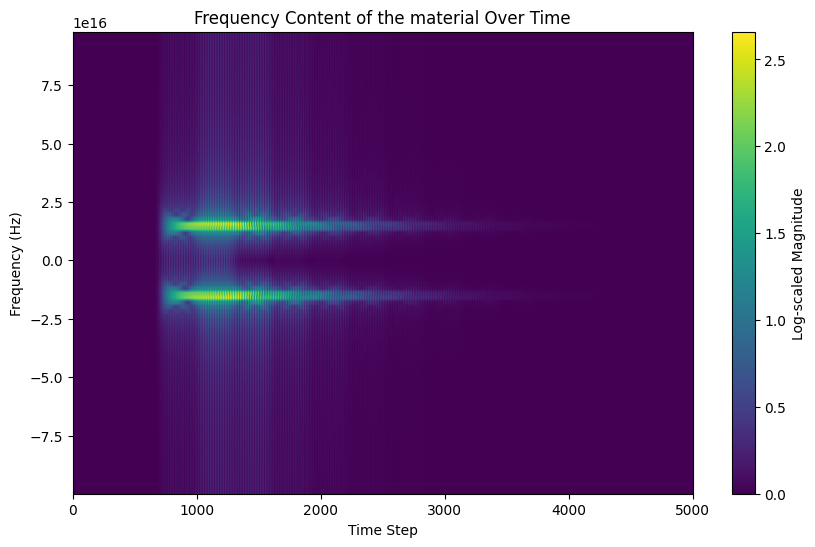

In [16]:
# Frequency axis setup
N = region_end - region_start  # Number of points in FFT
# Frequency array preparation (assuming dt is your sampling interval)
frequency_bins = np.fft.fftshift(np.fft.fftfreq(N, d=dt))

# Frequency analysis setup
frequency_content = np.zeros((nmax, N))

for n in range(nmax):
    region_data = Ex_all[n, region_start:region_end]
    fft_result = np.fft.fftshift(np.fft.fft(region_data))
    frequency_content[n, :] = np.abs(fft_result)

# Normalize frequency content for better visualization
frequency_content = np.log1p(frequency_content)  # Logarithmic scale for better visibility

# Visualizing the frequency content over time
plt.figure(figsize=(10, 6))
plt.imshow(frequency_content.T, aspect='auto', origin='lower',
           extent=[0, nmax, frequency_bins[0], frequency_bins[-1]])
plt.colorbar(label='Log-scaled Magnitude')
plt.xlabel('Time Step')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Content of the material Over Time')
plt.show()

As expected, we only see two frequency components in our material.

Now, let's add some nonlinearity, setting $\Chi^{(2)} = 5$.

In [17]:
Ex_all = np.zeros((nmax, jmax))
Dx_all = np.zeros((nmax, jmax))
Hz_all = np.zeros((nmax, jmax))

eps = np.ones(jmax)*epsilon0
eps[region_start:region_end] = 9*epsilon0
X2 = np.zeros(jmax)
X2[region_start:region_end] = 2

# Simulation loop
for n in range(1, nmax): # Looping across all time steps
    Hz_all[n, jmax-1] = Hz_all[n-1, jmax-2] # Mur boundary condition
    for j in range(jmax-1): #looping across all space steps
        Hz_all[n, j] = Hz_all[n-1, j] + dt / (dx * mu0) * (Ex_all[n-1, j+1] - Ex_all[n-1, j]) # Updating Hz
    Hz_all[n, jsource-1] -= source_CW(n) / imp0 # Adding the magnetic source term
    Ex_all[n, 0] = Ex_all[n-1, 1] # Mur boundary condition
    for j in range(1, jmax): # Looping across all space steps
        Dx_all[n, j] = Dx_all[n-1, j] + dt / (dx) * (Hz_all[n, j] - Hz_all[n, j-1]) # Updating Dx
        Ex_all[n, j] = Dx_all[n, j] / (eps[j]+epsilon0*X2[j]*Ex_all[n, j-1]) # Updating Ex
    Ex_all[n, jsource] += source_CW(n+1) # Adding the electric source term

def plot_frame(n=0):
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plotting the Electric field
    color = 'tab:red'
    ax1.plot(Ex_all[n, :], color=color)
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Electric Field (V/m)', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_title(f"Electric Field and Permittivity at Time Step: {n}")

    # Create a second y-axis for the permittivity
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.plot(eps / epsilon0, color=color)  # Normalize eps by epsilon0 for better visibility
    ax2.set_ylabel('Relative Permittivity (ε/ε₀)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 11)  # Adjust y-limit to permittivity range

    plt.show()

# Create an interactive widget
interact(plot_frame, n=IntSlider(min=0, max=nmax-1, step=1, value=0, description='Time Step'))

interactive(children=(IntSlider(value=0, description='Time Step', max=4999), Output()), _dom_classes=('widget-…

<function __main__.plot_frame(n=0)>

We can already see signs of higher order frequencies by looking at the waveform right after the thin-film.

Looking at this in the frequency domain, we can clearly see higher-order harmonics appearing.

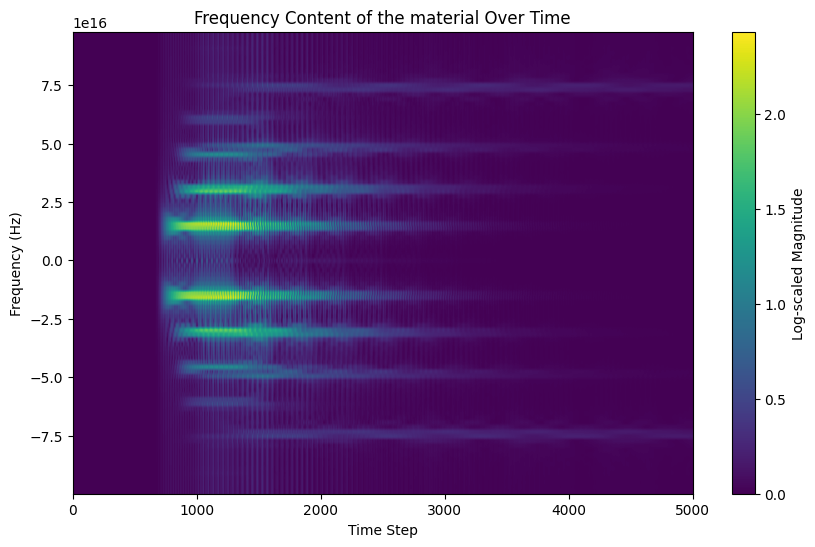

In [19]:
# Frequency axis setup
N = region_end - region_start  # Number of points in FFT
# Frequency array preparation (assuming dt is your sampling interval)
frequency_bins = np.fft.fftshift(np.fft.fftfreq(N, d=dt))

# Frequency analysis setup
frequency_content = np.zeros((nmax, N))

for n in range(nmax):
    region_data = Ex_all[n, region_start:region_end]
    fft_result = np.fft.fftshift(np.fft.fft(region_data))
    frequency_content[n, :] = np.abs(fft_result)

# Normalize frequency content for better visualization
frequency_content = np.log1p(frequency_content)  # Logarithmic scale for better visibility

# Visualizing the frequency content over time
plt.figure(figsize=(10, 6))
plt.imshow(frequency_content.T, aspect='auto', origin='lower',
           extent=[0, nmax, frequency_bins[0], frequency_bins[-1]])
plt.colorbar(label='Log-scaled Magnitude')
plt.xlabel('Time Step')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Content of the material Over Time')
plt.show()

An immediate critique is that we see not only the second harmonic, but higher-order harmonics as well. This is expected and would be difficult to fix. Since my implementation of instantaneous nonlinearity is boardband, every new frequency will experience the same $\Chi^{(2)}$. Thus, the second-harmonic will create the third, the fourth, etc. One possible treatment is that we can extend this simulation to 2D. There, we can define a waveguide that only supports 2 of those modes, thus restriction our process to only the second harmonic.

### Discussion

Overall, we've demonstrated 1D Nonlinear FDTD from scratch, looking into source terms, boundary conditions, linear and nonlinear responses. There are many ways one may extend this project. To 2D, 3D, and incorporating linear and nonlinear dispersion, which will allow simulations of solitons, Raman, and Brillouin scattering processes. One may also extend the analysis of second-harmonic generation by considering phase-matching conditions.

Some consequences of FDTD that we have observed:
1. FDTD is broadband. We saw how easy it is to observe mulitple frequencies in our simulation of second harmonic generation.
2. Though never explicitly stated, FDTD natively satisfies the Maxwell divergence equations.
3. It also natually satisfies the physica boundary conditions at material interfaces.
4. This very implementation is second-order accurate.

This project followed these two papers closely.

[1] K. Yee. Numerical solution of initial boundary value problems involving Maxwell’s equations in isotropic media (1966)

[2] R. Joseph, A. Taflove. FDTD Maxwell’s Equations Models for Nonlinear electrodynamics and Optics (1997)